In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv', index_col=None)
data

,level,long,lat
0,0,-0.130495,51.511534
1,0,-0.140844,51.514684
2,0,-0.135874,51.515684
3,0,-0.110329,51.518250
4,0,-0.125708,51.507725
...,...,...,...
8953,1,-0.134599,51.511608
8954,1,-0.125331,51.513753
8955,1,-0.131706,51.509404
8956,1,-0.147526,51.516597


In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


scaler = MinMaxScaler()
X = scaler.fit_transform(data.loc[:, ['long', 'lat']])
Y = scaler.fit_transform(data.loc[:, ['level']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [29]:
from keras_tuner.tuners import BayesianOptimization

def build_model(hp):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[2, 3]),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        input_shape=(X_train.shape[1], 1)))
        
    model.add(tf.keras.layers.MaxPooling1D(pool_size=1))

    model.add(tf.keras.layers.Dense(2))
    model.add(tf.keras.layers.Dense(2))

    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss', 
    max_trials=10,     
    executions_per_trial=10,
    directory='new_keras_optimise_logs', 
    project_name='keras_tuning'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Trial 10 Complete [00h 00m 00s]

Best val_loss So Far: 0.14503727555274964
Total elapsed time: 00h 01m 05s


In [30]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))

best_model.evaluate(X_test, Y_test)

Epoch 1/50
224/224 [==============================] - 0s 958us/step - loss: 0.1928 - val_loss: 0.1496
Epoch 2/50
224/224 [==============================] - 0s 650us/step - loss: 0.1466 - val_loss: 0.1470
Epoch 3/50
224/224 [==============================] - 0s 665us/step - loss: 0.1454 - val_loss: 0.1461
Epoch 4/50
224/224 [==============================] - 0s 846us/step - loss: 0.1447 - val_loss: 0.1457
Epoch 5/50
224/224 [==============================] - 0s 646us/step - loss: 0.1445 - val_loss: 0.1455
Epoch 6/50
224/224 [==============================] - 0s 721us/step - loss: 0.1444 - val_loss: 0.1453
Epoch 7/50
224/224 [==============================] - 0s 643us/step - loss: 0.1442 - val_loss: 0.1457
Epoch 8/50
224/224 [==============================] - 0s 723us/step - loss: 0.1440 - val_loss: 0.1453
Epoch 9/50
224/224 [==============================] - 0s 704us/step - loss: 0.1442 - val_loss: 0.1467
Epoch 10/50
224/224 [==============================] - 0s 751us/step - loss: 0.144

0.14357474446296692

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = best_model.predict(X_test)

56/56 [==============================] - 0s 441us/step


In [74]:
X_test[0]

array([0.27902274, 0.76869743])

In [49]:
best_model.predict(X_test)

56/56 [==============================] - 0s 476us/step


array([[[0.6800374 ]],

       [[0.675805  ]],

       [[0.58555156]],

       ...,

       [[0.6800374 ]],

       [[0.64729154]],

       [[0.6592656 ]]], dtype=float32)

1/1 [==============================] - 0s 15ms/step


array([[[0.38503104]]], dtype=float32)

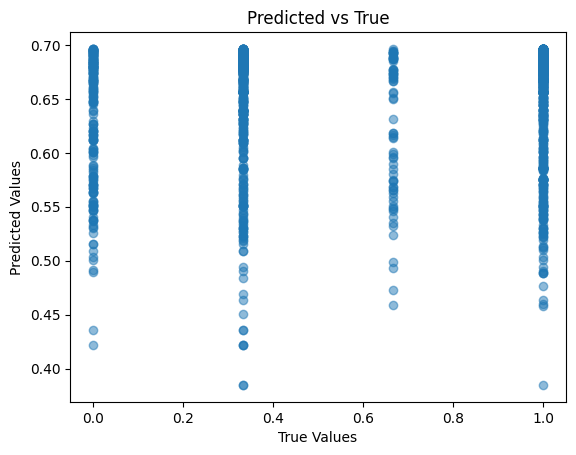

In [32]:
plt.scatter(Y_test[:, 0], predictions[:, 0], alpha=0.5)
plt.title("Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [33]:
mse_level = mean_squared_error(Y_test[:, 0], predictions[:, 0])
rmse_level = np.sqrt(mse_level)
mae_level = mean_absolute_error(Y_test[:, 0], predictions[:, 0])

print("Crime Level - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_level, rmse_level, mae_level))

Crime Level - MSE: 0.1436, RMSE: 0.3789, MAE: 0.3571


In [34]:
best_model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [72]:
model = tf.saved_model.load('./model')
data = scaler.fit_transform(np.array([[-0.1231, 51.23123]])).reshape(1, 2, 1)
prediction = model.signatures['serving_default'](tf.constant(data, dtype=tf.float32))
output_key = list(prediction.keys())[0]  
predicted_value = prediction[output_key].numpy()

print(predicted_value)

[[[0.646759]]]
